In [68]:
import os
import re
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [69]:
DATA_DIR = r'melspectrogram_images'
AUTOENCODER_SAVE_PATH = r'autoencoder_best.keras'
ENCODER_SAVE_PATH = r'encoder.keras'
DECODER_SAVE_PATH = r'decoder.keras'

IMG_HEIGHT = 104
IMG_WIDTH =  200
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

LATENT_DIM = 16

EPOCHS = 20
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EARLY_STOPPING_PATIENCE = 5

In [70]:
image_paths = glob.glob(os.path.join(DATA_DIR, '*.png'))
data = []
labels = []
for img_path in tqdm(image_paths, unit=" img"):
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img) / 255.0
    data.append(img_array)

    base_filename = os.path.basename(img_path)
    label = int(re.search(r'_label(\d+)\.png$', base_filename).group(1))
    labels.append(label)

data = np.asarray(data, dtype=np.float32)
labels = np.asarray(labels, dtype=np.int32)

x_train, x_val, y_train_labels, y_val_labels = train_test_split(
    data, labels,
    test_size=VALIDATION_SPLIT,
    random_state=42,
    shuffle=True
)

print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f'{labels[-10:]=}')

  0%|          | 0/399 [00:00<?, ? img/s]

100%|██████████| 399/399 [00:00<00:00, 806.70 img/s]

Training data shape: (319, 104, 200, 3)
Validation data shape: (80, 104, 200, 3)
labels[-10:]=array([4, 5, 6, 0, 1, 2, 3, 4, 5, 6], dtype=int32)


In [71]:
def build_encoder(input_shape, latent_dim):
    encoder_input = layers.Input(shape=input_shape, name="encoder_input")
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(encoder_input)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)

    latent_representation = layers.Conv2D(latent_dim, (3,3), activation='relu', padding='same', name="latent_rep")(x)
    encoder = keras.Model(encoder_input, latent_representation, name="encoder")
    return encoder

def build_decoder(latent_shape, output_channels):
    latent_input = layers.Input(shape=latent_shape, name="decoder_input")
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(latent_input)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)

    decoder_output = layers.Conv2DTranspose(output_channels, (3, 3), activation='sigmoid', padding='same', name="decoder_output")(x)
    decoder = keras.Model(latent_input, decoder_output, name="decoder")
    return decoder


encoder = build_encoder(INPUT_SHAPE, LATENT_DIM)
encoder_output_shape = encoder.output_shape[1:]
decoder = build_decoder(encoder_output_shape, IMG_CHANNELS)

autoencoder_input = layers.Input(shape=INPUT_SHAPE, name="autoencoder_input")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 104, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 13, 25, 16)     │        32,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 104, 200, 3)    │        32,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,619 (256.32 KB)

 Trainable params: 65,619 (256.32 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=EARLY_STOPPING_PATIENCE,
                             verbose=1,
                             restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath=AUTOENCODER_SAVE_PATH,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True)

history = autoencoder.fit(x_train, x_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        validation_data=(x_val, x_val),
                        callbacks=[early_stopping, model_checkpoint])

encoder.save(ENCODER_SAVE_PATH)
decoder.save(DECODER_SAVE_PATH)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0883
Epoch 1: val_loss improved from inf to 0.06660, saving model to autoencoder_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - loss: 0.0880 - val_loss: 0.0666
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0639
Epoch 2: val_loss improved from 0.06660 to 0.05790, saving model to autoencoder_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0640 - val_loss: 0.0579
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0594
Epoch 3: val_loss improved from 0.05790 to 0.05499, saving model to autoencoder_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0594 - val_loss: 0.0550
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0582
Epoch 4: val_loss improved from 0.05499 to 0.04889, saving model to autoencoder_best.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0579 - val_loss: 0.0489
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0499
Epoch

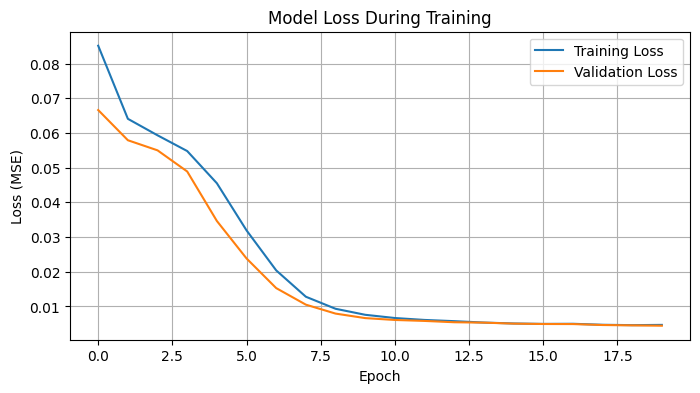

In [73]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


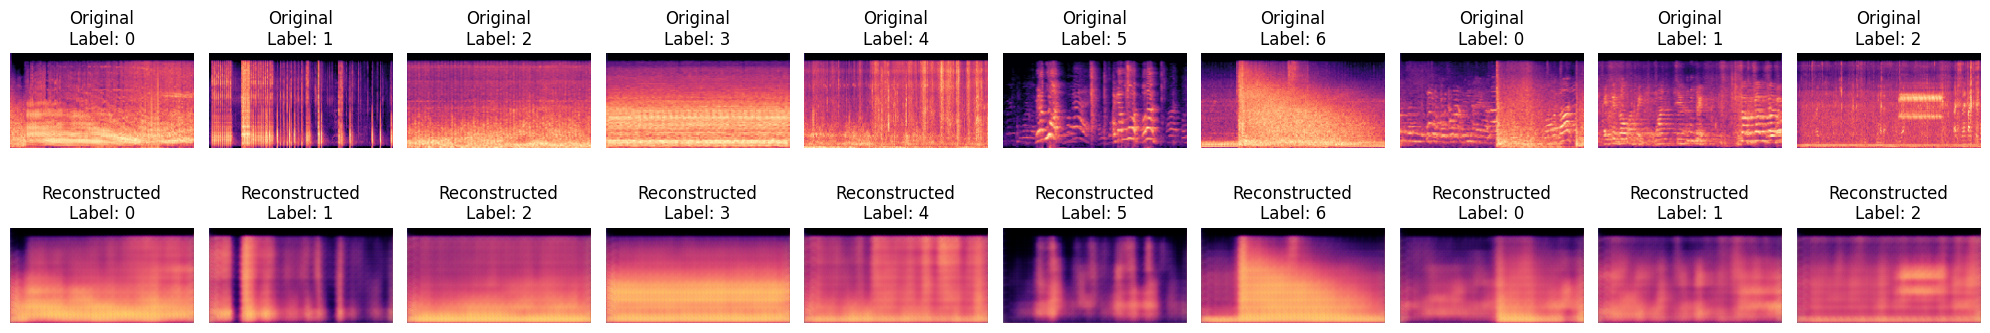

In [74]:
n_examples = 10
predictions = autoencoder.predict(x_val[:n_examples])
plt.figure(figsize=(20, 4))
for i in range(n_examples):
    plt.subplot(2, n_examples, i + 1)
    plt.imshow(x_val[i])
    current_label = labels[i]
    plt.title(f"Original\nLabel: {current_label}")
    plt.axis("off")

    plt.subplot(2, n_examples, i + 1 + n_examples)
    plt.imshow(predictions[i])
    plt.title(f"Reconstructed\nLabel: {current_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()